# U-Net Model

In [ ]:
import numpy as np
import h5py
Train = h5py.File('Train_7072.h5', 'r')
Test = h5py.File('Test_7072.h5', 'r')
Train_data = Train['data']
Test_data = Test['data']
Train_data = Train['data']
Test_data = Test['data']
Train_data = Train_data[:,6:,:64,:]
Test_data = Test_data[:,6:,:64,:]
Train_data.shape,Test_data.shape
Test_data_mod = np.moveaxis(Test_data,-1,1)
Test_data_mod = Test_data_mod.reshape(-1,64,64)
Test_data_mod.shape
Train_data_mod = np.moveaxis(Train_data,-1,1)
Train_data_mod = Train_data_mod.reshape(-1,64,64)
Train_data_mod.shape
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data, sequence_length=12, pred_length=3):
        self.sequence_length = sequence_length
        self.y = data
        self.X = data
        self.pred_length = pred_length
        
    def __len__(self):
        length = int(len(self.y)/8-self.sequence_length-self.pred_length+1)
        return length

    def __getitem__(self, i): 
        x = self.X[i*8:(i+self.sequence_length)*8,:,:]
        y = self.y[(i+self.sequence_length+self.pred_length-1)*8:(i+self.sequence_length+self.pred_length)*8,:,:]
        return torch.from_numpy(x).float(), torch.from_numpy(y).float()

In [ ]:
sequence_length = 12
pred_length = 3
TrainDataset = MyDataset(Train_data_mod,sequence_length=sequence_length, pred_length=pred_length)
X, y = TrainDataset[0]
print(X.shape)
print('Dataset length:',len(TrainDataset))
print(len(Train_data))

#Training set
train_dataset=MyDataset(Train_data_mod,sequence_length=sequence_length, pred_length=pred_length)
train_dataloader=torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)

#Test set
test_dataset=MyDataset(Test_data_mod,sequence_length=sequence_length, pred_length=pred_length)
test_dataloader=torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=True)

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.activation import Softmax

class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size = 3, padding=1),
            # nn.BatchNorm2d(out_ch), # added
            nn.ReLU(inplace=True), # added inplace=True
            nn.Conv2d(out_ch, out_ch, kernel_size = 3, padding=1),
            # nn.BatchNorm2d(out_ch), # added
            nn.ReLU(inplace=True) # added inplace=True
        )
    def forward(self, x):
        return self.block(x)


class Encoder(nn.Module):
    def __init__(self, chs=(96,128,128,128)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2,2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(128, 128, 128)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1): 
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x).to(device)
            x        = torch.cat([x, torch.Tensor(enc_ftrs)], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


class UNet(nn.Module):
    def __init__(self, enc_chs=(96, 128, 256), dec_chs=(256, 128), num_class=8, out_sz=(572,572)): # deleted argument: retain_dim=False
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Sequential(
            nn.Conv2d(dec_chs[-1], 32, 1),
            # nn.BatchNorm2d(32), # added
            nn.ReLU(inplace=True), # added inplace=True
            nn.Conv2d(32, num_class, 1),  # added
            nn.LeakyReLU(negative_slope=1e-4,inplace=True),
            nn.Tanh()
        )
        # self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = 255*self.head(out)
        # if self.retain_dim:
        #     out = F.interpolate(out, out_sz)
        return out

In [ ]:
#If there is a GPU avaiable for computations, we want to use it (else we will use a CPU)  "cuda:0" if torch.cuda.is_available() else 
device = torch.device("cpu")

In [ ]:
from tqdm import tqdm
def train_model(train_data_loader, model, loss_function, optimizer, device):

    model = model.to(device)
    model.train()
    loss_individual_epoch = 0
    for i, (images, labels) in tqdm(enumerate(train_data_loader),'Training progress within an epoch'):
        images=images.to(device)
#         labels=labels.float()
        labels=labels.to(device)
        # forward 
        outputs=model(images).to(device)
        loss=loss_function(outputs,labels)
        # backward and optimize 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_individual_epoch=loss_individual_epoch+loss.item()
#         if i<1:
#             print("Train individual loss: "+ str(loss_individual_epoch))
#         else:
#             print("Train individual loss: "+ str(loss_individual_epoch/i+1))
    loss_individual_epoch=loss_individual_epoch/i
    print("Train loss: "+ str(loss_individual_epoch))
    return loss_individual_epoch,model

In [ ]:
def test_model(data_loader, model, loss_function, device):
    
    num_batches = len(data_loader)
    # your code here #
    model = model.to(device)
    model.eval()
    total_loss = 0
    all_pred   = torch.tensor([]);
    all_labels = torch.tensor([]);
    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            """
            Fill your code after this
            """
            images, labels  = data
            images          = images.to(device)
            labels          = labels.to(device)

            # Perform forward pass
            outputs = model(images)

            # Compute loss
            loss = loss_function(outputs,labels)

            total_loss = total_loss + loss.item()
            
            all_labels   = torch.cat((all_labels,labels))
            all_pred     = torch.cat((all_pred,outputs))
            
#             if i<1:
#                 print("Test individual loss: "+ str(total_loss))
#             else:
#                 print("Test individual loss: "+ str(total_loss/(i+1)))
        
    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return all_pred,all_labels

In [ ]:
model = UNet()         # Define your model
loss_function = nn.MSELoss(reduction='mean')
print("Untrained test\n--------")
test_pred, test_labels = test_model(test_dataloader, model, loss_function, device)
print()

In [ ]:
learning_rate = 1e-3   # you can modify this parameter
epoch = 20              # you can modify this parameter
# model = UNet()         # Define your model
loss_function = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for ix_epoch in range(epoch):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss,model = train_model(train_dataloader,model,loss_function,optimizer,device)
    test_pred, test_labels = test_model(test_dataloader, model, loss_function,device)
    print()

In [ ]:
torch.save(model.state_dict(), 'unet0428_256_LeakyReLU.pth')

In [ ]:
h5f = h5py.File('unet0428_256_LeakyReLU_test.h5', 'w')
h5f.create_dataset('Test_pred', data=test_pred)
h5f.create_dataset('Test_labels', data=test_labels)
h5f.close()

# Results Analysis

In [18]:
import numpy as np
import h5py
h5f = h5py.File('unet0428_256_LeakyReLU_test_epoch10.h5','r')
test_pred = h5f['Test_pred'][:]
test_labels = h5f['Test_labels'][:]

In [19]:
np.sum(test_labels),np.sum(test_pred),np.sum(test_labels)-np.sum(test_pred)

(1663833000.0, 1518282600.0, 145550340.0)

In [20]:
test_AE = ((test_pred-test_labels)**2)**0.5
test_AE = np.reshape(test_AE, (-1,))
test_AE = np.array(test_AE)
test_AE.shape, np.mean(test_AE)

((282656768,), 6.868107)

In [21]:
test_SE  = (test_pred-test_labels)**2
test_MSE = np.mean(test_SE)
test_MSE

472.80136

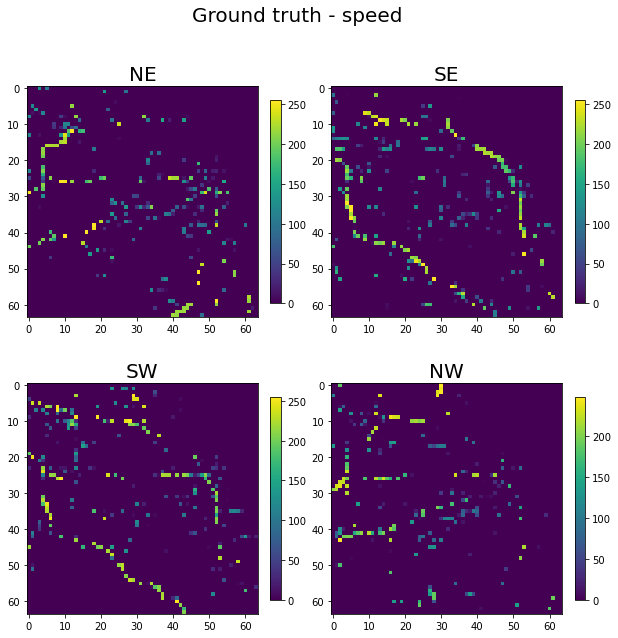

In [29]:
import matplotlib.pyplot as plt
DIR = ['NE','SE','SW','NW']
#2019-06-01 9 am
plt.figure(figsize=(10,10))
for i in range(4):
  X = np.array(test_labels[103*9,i+4,:,:])
  ax = plt.subplot(2,2,i+1)
  ax = plt.imshow(X,vmin=0)
  plt.colorbar(ax.colorbar, fraction=0.04)
  plt.title(str(DIR[i]),fontsize=20);
plt.suptitle('Ground truth - speed',fontsize=20)
plt.show()

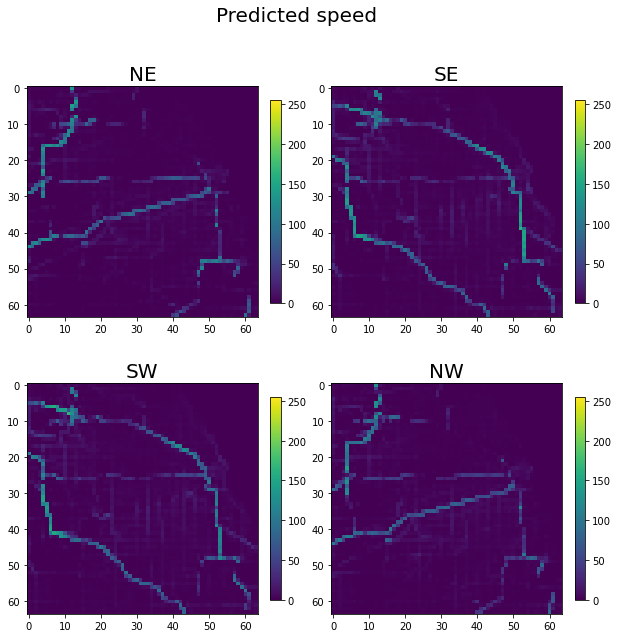

In [30]:
DIR = ['NE','SE','SW','NW']
#2019-06-01 9 am
plt.figure(figsize=(10,10))
for i in range(4):
  X = np.array(test_pred[103*9,i+4,:,:])
  ax = plt.subplot(2,2,i+1)
  ax = plt.imshow(X,vmin=0, vmax=255) # vmin=0, vmax=255
  plt.colorbar(ax.colorbar, fraction=0.04)
  plt.title(str(DIR[i]),fontsize=20);
plt.suptitle('Predicted speed',fontsize=20)
plt.show()

In [9]:
test_MAE=np.mean(test_AE)

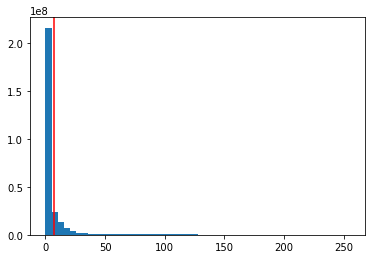

In [16]:
import matplotlib.pyplot as plt
plt.hist(test_AE,bins=50)
plt.axvline(x=test_MAE, ymin=0, ymax=1,color='r')

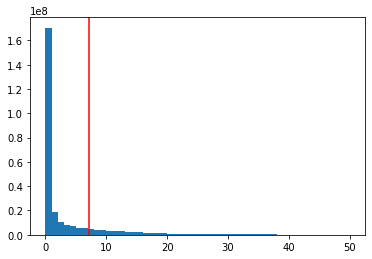

In [17]:
plt.hist(test_AE[test_AE<50],bins=50)
plt.axvline(x=test_MAE, ymin=0, ymax=1,color='r')